<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Составим краткий план работы над проектом:

* Загрузим и подготовим данные.
* Обучим разные модели. Для каждой попробуем различные гипепараметеры.
* Проанализируем скорость работы и качество моделей.

# Подготовка данных

In [1]:
# Отключим предупреждения Anaconda
import warnings

warnings.simplefilter("ignore")

# Будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns

sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

# Увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 8, 5

import math
from datetime import timedelta
from math import sqrt
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from xgboost import XGBRegressor

pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [2]:
def load_df(name_of_df, separator=",", ind=None):
    """Функция загружает датафрэйм и выводит основные данные по нему.
    Аргументы:
    name_of_df - путь к датафрэйму;
    separator - разделитель;
    ind - столбцы для использования в качестве номеров строк"""

    # Считаем и выведем первые 5 строк таблицы
    df = pd.read_csv(name_of_df, sep=separator, index_col=ind)
    print("Выведем первые 5 строк таблицы:", end="\n\n")
    display(df.head())

    # Вывод основных описательных статистик, общей информации о таблице,
    # пропущенных значений, корреляции признаков, количества дубликатов в данных
    print(
        "\n\n\n\nОтобразим основные описательные статистики по признакам:", end="\n\n"
    )
    display(df.describe())
    print("\n\n\n\nПолучим общую информацию о таблице:", end="\n\n")
    display(df.info())
    print(f"\n\n\n\nПропущенные значения по признакам:", end="\n\n")
    display(pd.DataFrame(df.isnull().sum(), columns=["missing_values"]))
    print(f"\n\n\n\nКорреляция признаков:", end="\n\n")
    display(df.corr())
    return df

In [3]:
car_df = load_df("autos.csv")

Выведем первые 5 строк таблицы:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21






Отобразим основные описательные статистики по признакам:



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 n

None





Пропущенные значения по признакам:



,missing_values
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895






Корреляция признаков:



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000,0.027,0.159,-0.333,0.111,NaN,0.076
RegistrationYear,0.027,1.000,-0.001,-0.053,-0.012,NaN,-0.003
Power,0.159,-0.001,1.000,0.024,0.043,NaN,0.022
Kilometer,-0.333,-0.053,0.024,1.000,0.010,NaN,-0.008
RegistrationMonth,0.111,-0.012,0.043,0.010,1.000,NaN,0.014
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076,-0.003,0.022,-0.008,0.014,NaN,1.000


В датафрэйме имеются 354 369 объектов (строк) и 16 признаков (столбцов). Ряд признаков имеют целочисленный тип данных (int64), а остальная часть содержит строки (тип object). Опишем признаковое пространство:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевым признаком является:
* Price — цена (евро)

Выделим ключевые моменты, которые мы увидели при ознакомлении с датасэтом:
* Имеются пропущенные значения
* Наименования столбцов следует скорректировать: привести к нижнему регистру, присвоить более содержательные наименования
* Имеется тип object, следовательно, необходимо будет выполнить кодировку значений с помощью OneHotEncoder или Ordinal Encoding

Обратим внимание на пропуски. Число пропусков по признакам:

* VehicleType - тип автомобильного кузова (37 490 шт.)
* Gearbox - тип коробки передач (19 833 шт.)
* Model - модель автомобиля (19 705 шт.)
* FuelType - тип топлива (32 895 шт.)
* NotRepaired - была машина в ремонте или нет (71 154 шт.)


Вероятнее всего, пропуски возникли в результате того, что клиент, заполняя форму о продаже автомобиля, не указал те или иные данные. Однако, если в случае с признаком NotRepaired пропуск интуитивно понятен - можно предположить, что машина не была в ремонте, то в случае с признаками Gearbox, Model - нет, ведь они напрямую влияют на стоимость автомобиля.

Для начала приведем столбцы к нижнему регистру, а также изменим наименования.

In [4]:
car_df.columns = car_df.columns.str.lower()
car_df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [5]:
car_df.rename(
    {
        "vehicletype": "body",
        "registrationyear": "reg_year",
        "kilometer": "car_mileage",
        "power": "hp",
        "gearbox": "gear",
        "datecreated": "date",
        "fueltype": "fuel",
    },
    axis=1,
    inplace=True,
)

Перейдем к обработке пропусков. В первую очередь избавимся от тех объектов, где имеются пропуски в признаке model, т.к. в случае пропуска оценить стоимость автомобиля не представляется возможным.

In [6]:
car_df.dropna(subset=["model"], inplace=True)
pd.DataFrame(car_df.isnull().sum(), columns=["missing_values"])

,missing_values
datecrawled,0
price,0
body,30662
reg_year,0
gear,15702
hp,0
model,0
car_mileage,0
registrationmonth,0
fuel,25732


Заметим, что пропуски в столбце body можно заполнить: для этого создадим столбец, который содержит в себе значения с наименованием модели и бренда для каждого автомобиля. После этого, мы сможем выполнить группировку по этому столбцу

In [7]:
car_df["brand_model"] = car_df["brand"] + " " + car_df["model"]

Теперь заполним пропущенные значения в столбце body с помощью моды, посчитанной по сгруппированным данным.

In [8]:
bodies = car_df.groupby("brand_model").agg(lambda x: x.mode(dropna=False)[0])["body"]
bodies

brand_model
alfa_romeo 145      small
alfa_romeo 147      sedan
alfa_romeo 156      wagon
alfa_romeo 159      wagon
alfa_romeo other    sedan
                    ...  
volvo v40           wagon
volvo v50           wagon
volvo v60           wagon
volvo v70           wagon
volvo xc_reihe        suv
Name: body, Length: 297, dtype: object

In [9]:
car_df.loc[car_df["body"].isna(), "body"] = car_df.loc[
    car_df["body"].isna(), "brand_model"
].apply(lambda x: bodies[x])
pd.DataFrame(car_df.isnull().sum(), columns=["missing_values"])

,missing_values
datecrawled,0
price,0
body,10
reg_year,0
gear,15702
hp,0
model,0
car_mileage,0
registrationmonth,0
fuel,25732


Мы избавились практически от всех пропусков в столбце body, отлично! Обработать остальные пропуски не представляется возможным, поэтому можно удалить наблюдения, которые содержат пропуски.

In [10]:
car_df.dropna(inplace=True)

In [11]:
# Проверим корректность преобразований

pd.DataFrame(car_df.isnull().sum(), columns=["missing_values"])

,missing_values
datecrawled,0
price,0
body,0
reg_year,0
gear,0
hp,0
model,0
car_mileage,0
registrationmonth,0
fuel,0


После преобразований избавимся от столбца brand_model, т.к. по сути он дублирует значения столбцов brand и model.

In [12]:
car_df.drop("brand_model", axis=1, inplace=True)

Проанализируем значения по признакам, т.к. в некоторых из них могут быть аномальные и некорректные значения.

In [13]:
car_df.describe()

,price,reg_year,hp,car_mileage,registrationmonth,numberofpictures,postalcode
count,253905.000,253905.000,253905.000,253905.000,253905.000,253905.000,253905.000
mean,5058.891,2003.367,118.838,127438.885,6.138,0.000,51345.915
std,4699.771,23.242,143.284,37046.428,3.502,0.000,25838.339
min,0.000,1600.000,0.000,5000.000,0.000,0.000,1067.000
25%,1450.000,1999.000,75.000,125000.000,3.000,0.000,30916.000
50%,3450.000,2004.000,110.000,150000.000,6.000,0.000,50670.000
75%,7444.000,2008.000,150.000,150000.000,9.000,0.000,72250.000
max,20000.000,9000.000,20000.000,150000.000,12.000,0.000,99998.000


Обратим особое внимание на целевой признак Price. Очевидно, что минимальное значение должно быть строго больше 0, однако, машины, которые стоят 1-100 евро тоже вызывают подозрение. Посмотрим на боксплот по признаку Price.

In [14]:
def boxplot(dataframe, clmn, without_outliers=False, rng=None):
    """Функция автоматизирует построение графика boxplot"""

    if not rng and without_outliers:
        Q1 = dataframe[clmn].quantile(0.25)
        Q3 = dataframe[clmn].quantile(0.75)
        IQR = Q3 - Q1
        a = Q1 - 2 * IQR
        b = Q3 + 2 * IQR
        rng = (a, b)

    dataframe.boxplot(column=clmn, grid=True)

    name = clmn
    try:
        name = name.split("_")
        name = " ".join(name)
        plt.ylabel(f"{name} values")
    except:
        plt.ylabel(f"{name} values")
    plt.ylim(rng)
    if without_outliers:
        plt.title(f"Boxplot of {name} without outliers")
    else:
        plt.title(f"Boxplot of {name}")

    plt.show()

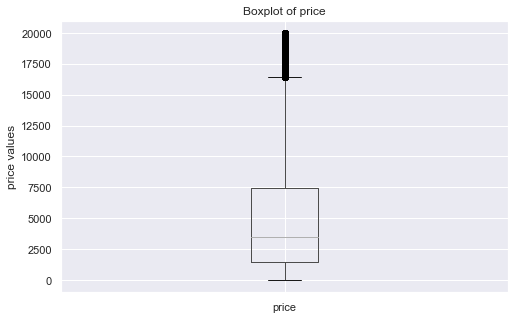

In [15]:
boxplot(car_df, "price")

In [16]:
def hist(dataframe, clmn, bns, without_outliers=False, rng=None):
    """Функция автоматизирует построение графика hist. 
    Для наглядности при without_outliers=True
    взяли не 1,5 межквартильных размаха, а 2"""
    if not rng and without_outliers:
        Q1 = dataframe[clmn].quantile(0.25)
        Q3 = dataframe[clmn].quantile(0.75)
        IQR = Q3 - Q1
        a = max(Q1 - 2 * IQR, dataframe[clmn].min())
        b = Q3 + 2 * IQR
        rng = (a, b)

    dataframe.plot(kind="hist", y=clmn, bins=bns, legend=True, range=rng, grid=True)
    name = clmn
    try:
        name = name.split("_")
        name = " ".join(name)
        plt.xlabel(f"{name} values")
    except:
        plt.xlabel(f"{name} values")
    if without_outliers:
        plt.title(f"Histogram of {name} values without outliers")
    else:
        plt.title(f"Histogram of {name} values")

    plt.show()

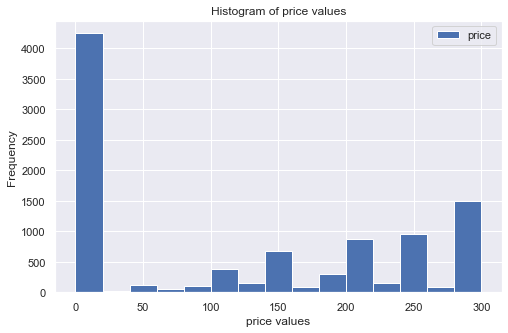

In [17]:
hist(car_df, "price", 15, rng=(0, 300))

Идея отсечения нижнего порога стоимости по межквартильным интервалом успехом не увенчается: в диапазон 1,5 межквартильного размаха входят маленькие значения, в том числе и 0. Однако, сделаем допущение, что автомобиль не может продаваться по стоимости менее чем 100 евро.

In [18]:
len(car_df[car_df["price"] < 100]) / len(car_df)

0.0178649494889821

Доля объектов, стоимость которых равна нулю составляет всего 0.032, поэтому исключим ее из результирующей таблицы, которую в дальнейшем будем использовать для обучения моделей.

Также аномалии имеются в признаках reg_year, который можно ограничить значениями от 1975 года до 2020; hp, где минимальное значение должно быть больше 0. Посмотрим какая доля данных будет исключена из результирующей выборки:

In [19]:
len(car_df[(car_df["reg_year"] < 1975) | (car_df["reg_year"] > 2020)]) / len(car_df)

0.00384395738563636

In [20]:
len(car_df[car_df["hp"] == 0]) / len(car_df)

0.04595419546680845

Таким образом, после исключения аномальных значений, в результирующем датасэте будет приблизительно на 14% данных меньше, чем в изначальном датасэте. Это немалая потеря данных, однако, мы видим, что бОльшая часть из них удаляются в результате исключения наблюдений, где мощность равна 0. Учитывая то, что мощность оказывает большое влияние на стоимость (см. таблицу корреляций выше), исключение таких наблюдений просто необходимо.

Также отметим, что признаковое пространство для обучения моделей избыточно, т.к., например, количество фотографий и почтовый индекс пользователя не могут оказывать какого-либо влияния на стоимость автомобиля. Также дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, дата последней активности пользователя также не влияют на стоимость. Даже если предположить, что, например, признаки LastSeen или DateCreated могут оказывать какое-либо влияние на стоимость ввиду того, что они являются характеристикой времени, даже в таком случае их тоже можно исключить без потери качества предсказаний, т.к. это учтено в признаке RegistrationYear (год регистрации автомобиля). Таким образом, в датасэте для последующего обучения модели избавимся от следующих признаков:
* DateCrawled — дата скачивания анкеты из базы
* RegistrationMonth — месяц регистрации автомобиля
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

In [21]:
changed_car_df = (
    car_df[
        (car_df["price"] >= 100)
        & ((car_df["reg_year"] >= 1975) & (car_df["reg_year"] <= 2020))
        & (car_df["hp"] > 0)
    ]
    .drop(
        [
            "datecrawled",
            "registrationmonth",
            "date",
            "numberofpictures",
            "postalcode",
            "lastseen",
        ],
        axis=1,
    )
    .copy()
)

In [22]:
len(changed_car_df) / len(car_df)

0.9358933459364723

Проверим уникальные значения столбца fuel:

In [23]:
car_df.fuel.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Petrol и gasoline - названия одного и того же топлива в Великобритании и США, поэтому имеет смысл привести их к одному наименованию - petrol.

In [24]:
car_df["fuel"].where(car_df["fuel"] != "gasoline", "petrol", inplace=True)
car_df.fuel.unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

## Вывод

Мы выполнили этап подготовки данных. Общая потеря данных составила 12,6%, что достаточно много, однако, для получения адекватных результатов на стадии обучения, было крайне важно избавиться от тех объектов, где стоимость автомобилей была подозрительно низкой, мощность автомобилей была равна нулю, а также имелись аномальные значения в признаке reg_year.

# Обучение моделей

Приступим к обучению моделей. Попробуем различные модели, а также будем подбирать наиболее параметры, влияющие на качество предсказания. В данном случае мы будем решать задачу регрессии - предсказания значения. В качестве метрики будет использоваться RMSE - Root Mean Squared Error. Напомним, что значение RMSE вычисляется по формуле:

$$RMSE=\sqrt{MSE}=\sqrt{\frac{1}{m} \cdot \sum_{i=1}^{m} ( a_i - y_i )^2},$$

где $m$ - число объектов, $( a_i - y_i )^2$ - квадрат отклонения предсказанных значений от реальных.

Также требуется выполнить преобразование категориальных признаки в численные, для этого используем прямое кодирование (One-Hot Encoding), a для бустинговых алгоритмов - OrdinalEncoding.

In [25]:
numerical_features = list(
    changed_car_df.select_dtypes(include=["int64", "float64"])
    .drop(["price"], axis=1)
    .columns
)

categorical_features = list(changed_car_df.select_dtypes(include=["object"]).columns)

In [26]:
changed_car_df_ohe = pd.get_dummies(
    changed_car_df, columns=categorical_features, drop_first=True
)

In [27]:
enc = OrdinalEncoder()
changed_car_df[categorical_features] = enc.fit_transform(
    changed_car_df[categorical_features]
)

Разделим выборку на обучающую и тестовую, чтобы избежать переобучения.

In [28]:
X_ohe = changed_car_df_ohe.drop("price", axis=1)
y_ohe = changed_car_df_ohe["price"]

X_oe = changed_car_df.drop("price", axis=1)
y_oe = changed_car_df["price"]

In [29]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y_ohe, test_size=0.3, random_state=1, shuffle=True
)

X_train_oe, X_test_oe, y_train_oe, y_test_oe = train_test_split(
    X_oe, y_oe, test_size=0.3, random_state=1, shuffle=True
)

In [30]:
# Создадим "контейнер", куда запишем значения основных характеристик модели

comparison_of_models = pd.DataFrame()

In [31]:
def model_plot(y_test, y_pred):
    """Функция строит графики для оценки модели.
    На первом графике показано качество предсказания модели.
    На втором - сравнение распределений целевого признака
    для тестовых данных и для предсказанных данных.
    Аргументы:
    y_test - тестовые данные целевого признака;
    y_pred - предсказанные данные целевого признака"""

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes[0].scatter(y_pred, y_test, alpha=0.3, label="Данные")
    axes[0].set_xlabel("Истинные значения")
    axes[0].set_ylabel("Предсказанные значения")
    x_vals = np.array(axes[0].get_xlim())
    y_vals = x_vals
    axes[0].plot(x_vals, y_vals, ls="--", c="red", label="Идеальное предсказание")
    axes[0].legend(loc="upper left")
    axes[0].set_title("Качество предсказания модели")

    axes[1].hist(y_test, bins=50, alpha=1, label="Истинные значения")
    axes[1].set_xlabel("Price")
    axes[1].hist(
        y_pred, bins=50, alpha=0.7, label="Предсказанные значения", color="red"
    )
    axes[1].legend(loc="upper right")
    axes[1].set_title("Распределение целевого признака")

In [32]:
def model_score_test(X_train, X_test, y_train, y_test, name, model, param_grid):
    """Функция строит предсказания с помощью линейной регрессии, подбирая наилучшие
    варианты преобразований с помощью Pipeline и GridSearchCV.
    Результатом работы функции являются график оценки модели,
    вывод наилучших вариантов преобразования модели,
    таблица со значениями метрик MAE, MSE, RMSE, R2.
    Аргументы:
    X_train - тренировочные данные для обучения модели;
    X_test - тестовые данные для предсказания целевого признака;
    y_train - значения целевого признака для обучения модели;
    y_test - значение целевого признака для вычисления метрик;
    name - наименование объекта;
    param_grid - сетка параметров."""

    global comparison_of_models
    start = timer()
    preprocessor = Pipeline(steps=[("scaler", "passthrough")])
    regressor = Pipeline(steps=[("preprocessor", preprocessor), ("model", model),])

    grid_search = GridSearchCV(
        regressor,
        param_grid=param_grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)
    end = timer()
    fit_time = str(timedelta(seconds=end - start))

    best_params = grid_search.best_params_

    start = timer()
    y_pred = grid_search.predict(X_test)
    end = timer()
    predict_time = str(timedelta(seconds=end - start))

    model_plot(y_test, y_pred)

    pred_MSE = mean_squared_error(y_test, y_pred)
    pred_RMSE = sqrt(pred_MSE)
    pred_R2 = r2_score(y_test, y_pred)

    temp_data = pd.DataFrame(
        {
            "Наименование алгоритма": [name],
            "Время обучения (сек.)": [fit_time],
            "Скорость предсказания (сек.)": [predict_time],
            "RMSE на обучении": [abs(grid_search.best_score_)],
            "RMSE предсказания": [pred_RMSE],
            "R2 предсказания": [pred_R2],
        }
    )
    if len(comparison_of_models) == 0:
        comparison_of_models = comparison_of_models.append(temp_data)
    elif name not in list(comparison_of_models["Наименование алгоритма"]):
        comparison_of_models = comparison_of_models.append(temp_data)
    else:
        comparison_of_models[
            comparison_of_models["Наименование алгоритма"] == name
        ] = temp_data

    comparison_of_models = comparison_of_models.reset_index(drop=True)
    print(
        f"Для улучшения модели использовались следующие параметры: {best_params}",
        end="\n\n",
    )
    return comparison_of_models

Все готово к обучению моделей. Обучим следующие модели:
* Линейная регрессия;
* XGBRegressor;
* LGBMRegressor;
* CatBoostRegressor.

Помимо основной метрики RMSE также справочно отразим значения метрики R2, которая показывает, насколько наша модель лучше той, которая предсказывает средние значения.
Для подбора наилучших параметров будет использован Pipeline.

In [33]:
param_grid_lin_regr = [
    {"preprocessor__scaler": [RobustScaler()]}
]

Для улучшения модели использовались следующие параметры: {'preprocessor__scaler': RobustScaler()}



,Наименование алгоритма,Время обучения (сек.),Скорость предсказания (сек.),RMSE на обучении,RMSE предсказания,R2 предсказания
0,LinearRegression,0:00:13.578092,0:00:00.226982,2688.215,2664.785,0.679


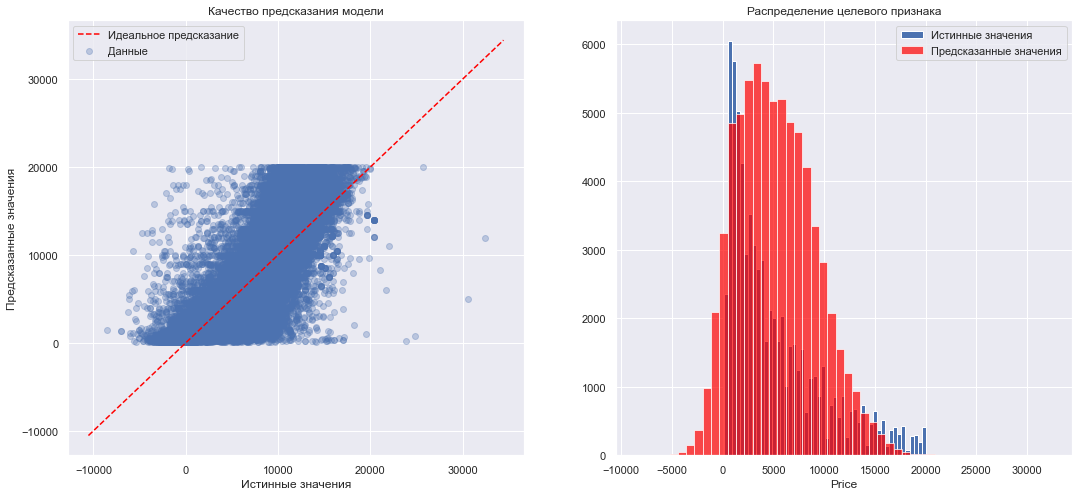

In [34]:
model_score_test(
    X_train_ohe,
    X_test_ohe,
    y_train_ohe,
    y_test_ohe,
    "LinearRegression",
    LinearRegression(),
    param_grid_lin_regr,
)

Линейная регрессия имеет высокую скорость обучения и предсказания, однако, R2 модели сигнализирует о том, что она показывает средние результаты. Также на правом графике видно, что предсказанное распределение достаточно слабо аппроксимирует истинные значения.

Перейдём к обучению XGBRegressor.

In [35]:
param_grid_xgboost = [
    {
        "preprocessor__scaler": [StandardScaler(), RobustScaler(),],
        "model__n_estimators": [150, 300],
        "model__max_depth": [8, 9],
    }
]

In [36]:
model_xgbregressor = XGBRegressor(
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10,
    verbose=True,
)

[23:40:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Для улучшения модели использовались следующие параметры: {'model__max_depth': 9, 'model__n_estimators': 300, 'preprocessor__scaler': StandardScaler()}



,Наименование алгоритма,Время обучения (сек.),Скорость предсказания (сек.),RMSE на обучении,RMSE предсказания,R2 предсказания
0,LinearRegression,0:00:13.578092,0:00:00.226982,2688.215,2664.785,0.679
1,XGBRegressor,0:03:35.672919,0:00:00.369924,1517.360,1497.314,0.899


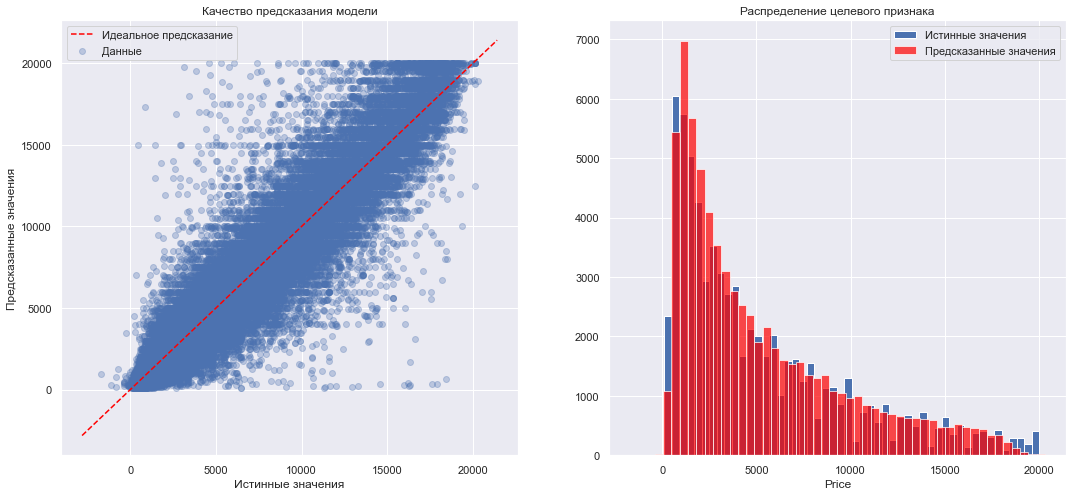

In [37]:
model_score_test(
    X_train_oe,
    X_test_oe,
    y_train_oe,
    y_test_oe,
    "XGBRegressor",
    model_xgbregressor,
    param_grid_xgboost,
)

XGBRegressor показывает куда лучшие результаты по сравнению с линейной регрессией, однако, обучение модели занимает существенно больше времени, а для нас оно также важно.

Перейдём к обучению модели LGBMRegressor и посмотрим на результаты.

In [38]:
param_grid_lgbmregressor = [
    {
        "preprocessor__scaler": [StandardScaler(), RobustScaler(),],
        "model__n_estimators": np.arange(500, 700, 100),
        "model__max_depth": np.arange(10, 12),
    }
]

In [39]:
model_lgbmregressor = LGBMRegressor(learning_rate=0.2, random_state=42, n_jobs=-1,)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Для улучшения модели использовались следующие параметры: {'model__max_depth': 10, 'model__n_estimators': 600, 'preprocessor__scaler': RobustScaler()}



,Наименование алгоритма,Время обучения (сек.),Скорость предсказания (сек.),RMSE на обучении,RMSE предсказания,R2 предсказания
0,LinearRegression,0:00:13.578092,0:00:00.226982,2688.215,2664.785,0.679
1,XGBRegressor,0:03:35.672919,0:00:00.369924,1517.360,1497.314,0.899
2,LGBMRegressor,0:00:36.481726,0:00:00.369840,1525.997,1507.049,0.897


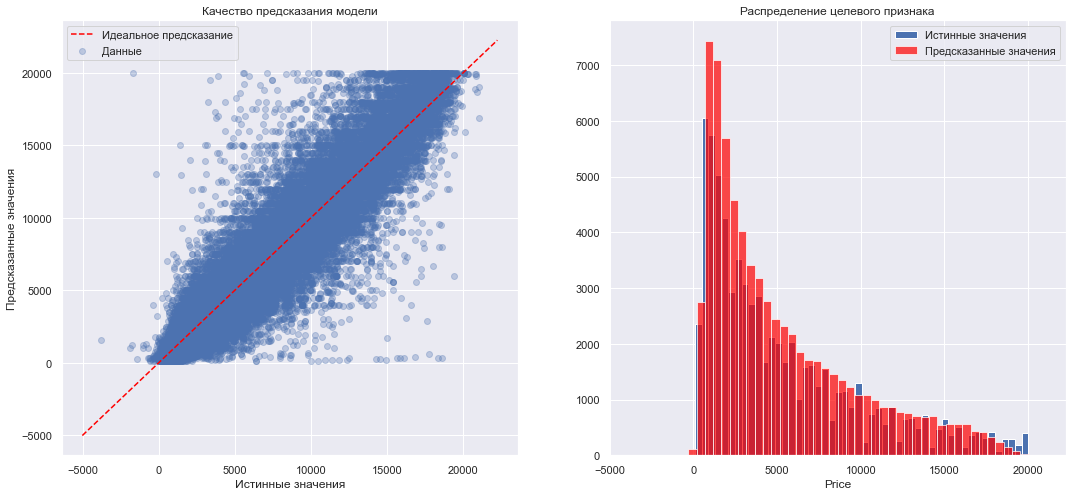

In [40]:
model_score_test(
    X_train_oe,
    X_test_oe,
    y_train_oe,
    y_test_oe,
    "LGBMRegressor",
    model_lgbmregressor,
    param_grid_lgbmregressor,
)

LGBMRegressor демонстрирует великолепные результаты по сравнению с другими моделями: время обучения в 3 раза меньше, нежели у XGBRegressor практически при том же качестве предсказаний.

Посмотрим, как себя зарекомендует CatBoostRegressor.

In [41]:
param_grid_catboostregressor = [
    {
        "preprocessor__scaler": [StandardScaler(), RobustScaler(),],
        "model__n_estimators": [50, 300],
        "model__max_depth": [7, 8],
    }
]

In [42]:
model_catboostregressor = CatBoostRegressor(
    learning_rate=0.5, random_state=42, early_stopping_rounds=10
)

0:	learn: 3230.2138424	total: 183ms	remaining: 54.7s
1:	learn: 2577.3441092	total: 200ms	remaining: 29.8s
2:	learn: 2264.4500867	total: 215ms	remaining: 21.3s
3:	learn: 2113.1439202	total: 231ms	remaining: 17.1s
4:	learn: 2039.8371228	total: 246ms	remaining: 14.5s
5:	learn: 1980.9545709	total: 263ms	remaining: 12.9s
6:	learn: 1935.6295775	total: 279ms	remaining: 11.7s
7:	learn: 1912.2341721	total: 294ms	remaining: 10.7s
8:	learn: 1894.5284512	total: 309ms	remaining: 9.97s
9:	learn: 1876.1148330	total: 324ms	remaining: 9.41s
10:	learn: 1847.5486196	total: 340ms	remaining: 8.94s
11:	learn: 1827.5841408	total: 355ms	remaining: 8.53s
12:	learn: 1815.1056654	total: 371ms	remaining: 8.2s
13:	learn: 1801.5270472	total: 388ms	remaining: 7.93s
14:	learn: 1790.7699057	total: 405ms	remaining: 7.69s
15:	learn: 1778.9410172	total: 425ms	remaining: 7.55s
16:	learn: 1767.7955555	total: 442ms	remaining: 7.36s
17:	learn: 1755.5380981	total: 459ms	remaining: 7.19s
18:	learn: 1742.6748834	total: 475ms	re

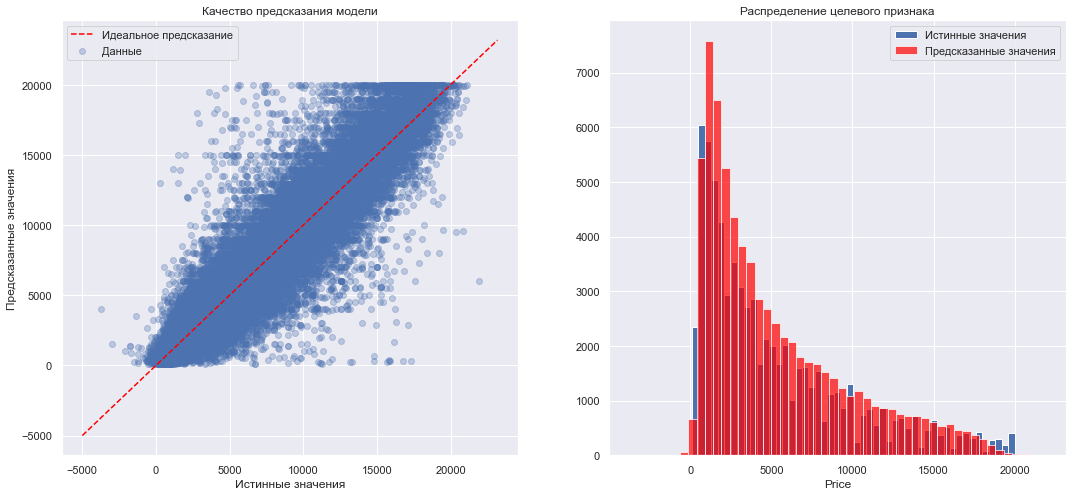

In [43]:
comparison = model_score_test(
    X_train_oe,
    X_test_oe,
    y_train_oe,
    y_test_oe,
    "CatBoostRegressor",
    model_catboostregressor,
    param_grid_catboostregressor,
)

In [44]:
comparison

,Наименование алгоритма,Время обучения (сек.),Скорость предсказания (сек.),RMSE на обучении,RMSE предсказания,R2 предсказания
0,LinearRegression,0:00:13.578092,0:00:00.226982,2688.215,2664.785,0.679
1,XGBRegressor,0:03:35.672919,0:00:00.369924,1517.360,1497.314,0.899
2,LGBMRegressor,0:00:36.481726,0:00:00.369840,1525.997,1507.049,0.897
3,CatBoostRegressor,0:01:53.308693,0:00:00.023052,1550.962,1534.372,0.894


In [45]:
# Переведём столбцы со временем в наносекунды
comparison["Время обучения (сек.)"] = pd.to_timedelta(comparison["Время обучения (сек.)"]).astype('int64')
comparison["Скорость предсказания (сек.)"] = pd.to_timedelta(comparison["Скорость предсказания (сек.)"]).astype('int64')

comparison.rename(
    {
        "Время обучения (сек.)": "Время обучения (наносек.)",
        "Скорость предсказания (сек.)": "Скорость предсказания (наносек.)"
    },
    axis=1,
    inplace=True,
)

In [46]:
comparison

,Наименование алгоритма,Время обучения (наносек.),Скорость предсказания (наносек.),RMSE на обучении,RMSE предсказания,R2 предсказания
0,LinearRegression,13578092000,226982000,2688.215,2664.785,0.679
1,XGBRegressor,215672919000,369924000,1517.360,1497.314,0.899
2,LGBMRegressor,36481726000,369840000,1525.997,1507.049,0.897
3,CatBoostRegressor,113308693000,23052000,1550.962,1534.372,0.894


CatBoostRegressor не удалось превзойти результаты XGBRegressor и LGBMRegressor по метрике RMSE, да и кроме того обучение занимает больше времени, нежели при обучении модели LGBMRegressor.

## Вывод 

Мы обучили несколько моделей и зафиксировали их основные показатели. 


Мы обучили три модели, использующие градиентный бустинг: LightGBM, XGBoost и CatBoost, а также одну модель LinearRegression.
Для каждой модели мы:
* Подобрали с помощью перебора по сетке такие параметры, при которых ошибка будет минимальной. Также использовали Pipeline;
* Измерили качество предсказаний при кросс-валидации на учебной и на тестовой выборке;
* Вычислили время, за которое производится обучение и предсказание.

Теперь все готово к анализу моделей и выбору наилучшего варианта.

# Анализ моделей

Text(0.5, 1.0, 'Сравнение метрики RMSE')

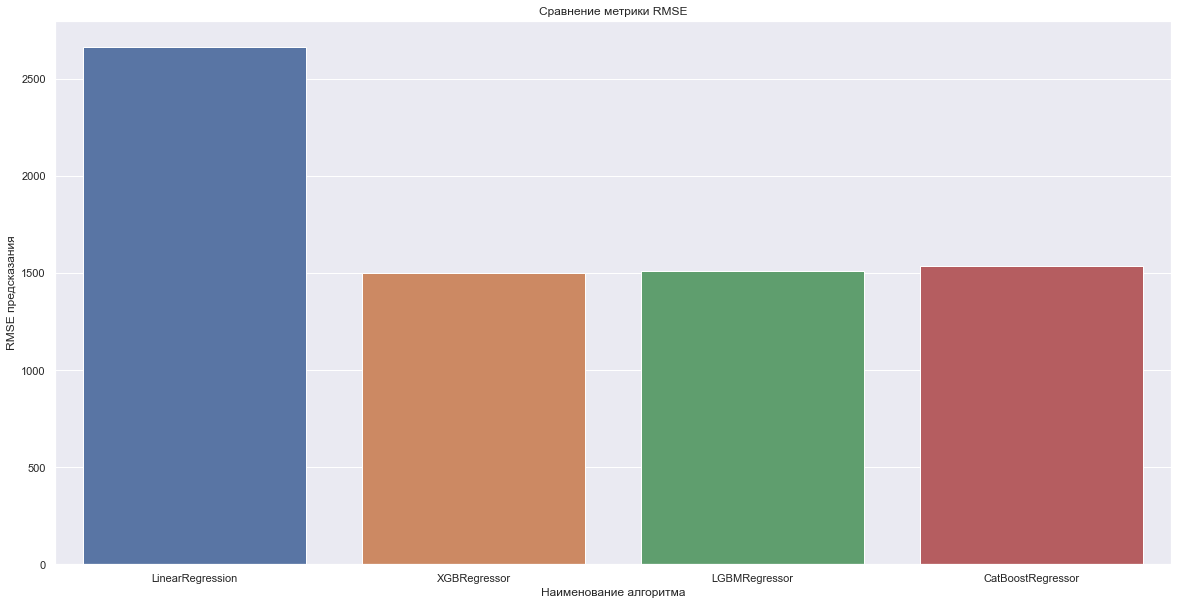

In [47]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    y=comparison["RMSE предсказания"],
    x=comparison["Наименование алгоритма"],
    orient="v",
)
ax.set_title("Сравнение метрики RMSE")

Text(0.5, 1.0, 'Сравнение времени обучения')

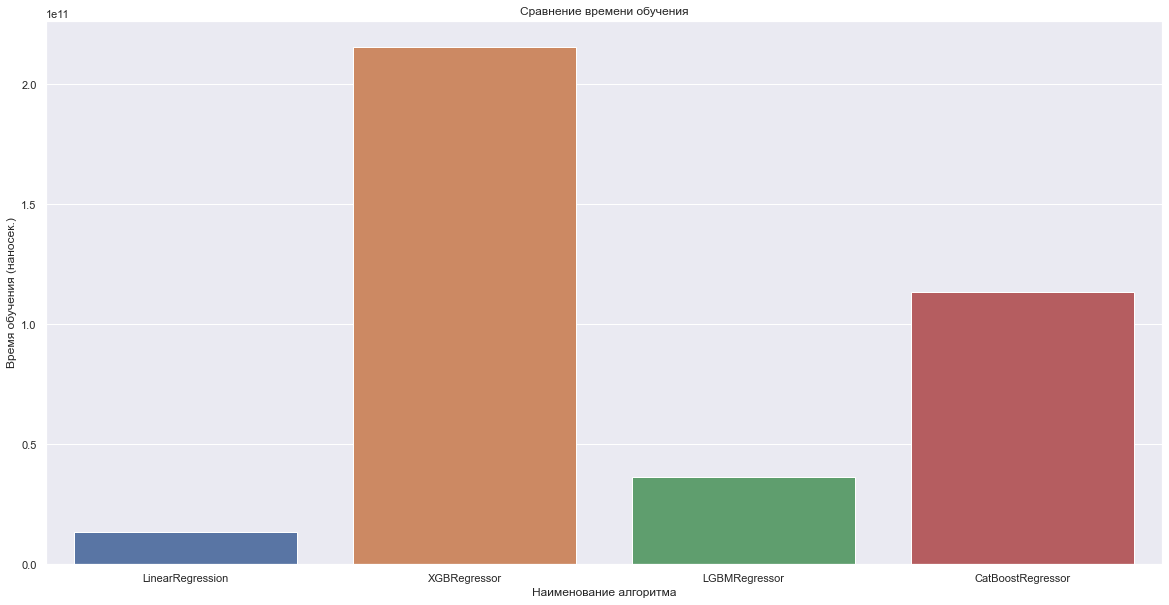

In [48]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(
    y=comparison["Время обучения (наносек.)"],
    x=comparison["Наименование алгоритма"],
    orient="v",
)
ax.set_title("Сравнение времени обучения")

Из графиков видно, что из бустинговых алгоритмов по времени предсказания однозначно лидирует LightGBM. Конечно, алгоритм линейной регрессии работает еще быстрее, однако его можно не рассматривать, т.к. качество предсказаний оставляет желать лучшего.

## Вывод

Мы визуализировали основные показателей моделей, проранжируем их в зависимости от скорости обучения и точности предсказаний.

1. LightGBM - Этот вариант является наиболее выигрышным: высокая скорость обучения сочетается с высоким значением метрики RMSE. Для предсказания стоимости автомобилей принимает эту модель;
2. CatBoost - CatBoost занимает второе место, она заметно ближе к LightGBM по скорости работы. Однако, значение метрики RMSE немного хуже, нежели чем у LightGBM;
3. XGBoost - несмотря на высокое значение метрики RMSE, обучение этой модели занимает очень долгое время, а в данном случае оно играет важное значение;
4. LinearRegression - иногда самые простые методы принсят лучшие результаты, однако, это не тот случай. Несмотря на молниеносную скорость обучения, значение метрики RMSE оставляет желать лучшего.

# Общий вывод

Целью нашего проекта был поиск модели градиентного бустинга, которую можно встроить в приложение, и которая будет рекомендовать стоимость автомобиля в зависимости от его характеристик и других факторов.

* Мы изучили данные из базы объявлений о продаже автомобилей, ознакомились со структурой а также некоторыми особенностями датафрэйма;
* Выполнили предобработку данных, по возможности заполняя пропуски в данных и удаляя аномальные значения, которые могут приводить к некорректным результатам при прогнозировании;
* Закодировали категориальные признаки при помощи методов One-Hot Encoder, Ordinal Encoder, разделили данные на выборки для обучения и тестирования, затем количественные признаки отмасштабировали с помощью Standard Scaler и Robust Scaler, обернув их в Pipeline;
* Обучили модели градиентного бустинга LightGBM, CatBoost и XGBoost при помощи поиска по сетке параметров. В качестве эксперимента также обучили модель линейной регрессии, однако, она показала наихудший результат по метрике RMSE;
* Провели сравнительный анализ и оценили достоинства и недостатки моделей. Рассмотрели возможности использования каждой модели;
* Сделали вывод, что лучшей моделью для решения нашей задачи будет LightGBM, т.к. при одной из лучших значений метрики RMSE она показала высокий результат по скорости обучения.